In [54]:
## Cell 1
## Import modules
import iris
import iris.quickplot as qplt
import iris.plot as iplt
from iris import *
from iris.analysis import *
from iris.analysis.cartography import *
from iris.coord_categorisation import *
import matplotlib.pyplot as plt
from scipy.stats import *
import sys
import numpy
import iris.coord_categorisation
from numpy import *
from matplotlib.pyplot import *
from scipy.stats.mstats import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import datetime as dt

## Define function to calculate area mean
def area_avg(enso_event_cube):
    try:
        enso_event_cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        enso_event_cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(enso_event_cube)
    enso_event_area_mean = enso_event_cube.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)
    return enso_event_area_mean

def annual_max(cube):
    try:
        iris.coord_categorisation.add_year(cube,'time', name='year2')
    except:
        pass
    return cube.aggregated_by('year2',iris.analysis.MAX)




In [102]:
## Cell 2
## Read in DHW data

## Read in cube
dhw_cube = iris.load_cube('/data/local_ssd/cj362/S2P3Rv2.0/dhw/dhw_script_outputs/GFDL-CM4_ssp245_daily_dhw.nc')
dhw_cube = annual_max(dhw_cube)
dhw_cube_name = "GFDL-CM4 ssp2(4.5)"

In [103]:
dhw_cube_data = dhw_cube.data

shape = np.shape(dhw_cube_data)                 # Returns the shape of the array

for i in range(shape[1]):                                  
    for j in range(shape[2]):
        if any(dhw_cube_data.mask[:,i,j]):
            dhw_cube.data.data[:,i,j] = dhw_cube.data.fill_value
            dhw_cube.data.mask[:,i,j] = True
            
            
dhw_cube.data = dhw_cube_data

In [3]:
## Cell 3
## Remove year and month scalar coordinates
## Eventhough we are going to add back in these coordinates later on,
## For some reason if we do not remove them in the first place it causes later variables to become recognised
## as NoneType objects rather than Iris Cubes.
## THIS CELL MUST BE RUN

# dhw_cube.remove_coord('year')
# dhw_cube.remove_coord('month')
# dhw_cube.remove_coord('month_number')

In [104]:
## Cell 4
## Detrending

## Define function to calculate line from which to detrend
def quadratic_function(x,a,b,c):    
    y = (a*(x**2.0)) + (b*x) + c
    return y

# def linear_function(x,a,c):    
#     y = a*x + c
#     return y

## Re-load in dhw cube data to be detrended
dhw_cube_detrended_1 = dhw_cube.copy()                      # Copy cube 
dhw_cube_detrended_1_data = dhw_cube_detrended_1.data       # Extract data

## Detrending processing
shape = np.shape(dhw_cube_detrended_1_data)                 # Returns the shape of the array
output_cube_data = dhw_cube_detrended_1_data.copy()         # Seperate cube to process the data
output_cube_data[:] = np.nan                                # Converts all values (:) in array to Nan
print(nanmin(dhw_cube_detrended_1_data))
print(nanmax(dhw_cube_detrended_1_data))

for i in range(shape[1]):                                  
    for j in range(shape[2]):
        if dhw_cube_detrended_1_data.mask[0,i,j] == False:
            parameters, var = curve_fit(quadratic_function,np.arange(shape[0]),dhw_cube_detrended_1_data[:,i,j])
            y_values_anomaly_from_curve = quadratic_function(np.arange(shape[0]), *parameters)
            output_cube_data[:,i,j] = dhw_cube_detrended_1_data[:,i,j]-y_values_anomaly_from_curve
            
print(nanmin(output_cube_data))
print(nanmax(output_cube_data))
print(dhw_cube_detrended_1)

# output_cube_data.data[np.where(np.isnan(output_cube_data))] = output_cube_data.fill_value
# # is finding all NANs and replacing them with the missing data value
# output_cube_data[np.where(output_cube_data < -1000)] = output_cube_data.fill_value
# # is finding all zero values and replacing them with the missing data clay
# output_cube_data.mask[np.where(np.isnan(output_cube_data))] = True
# # Masks data values that are Nans to True (meaning they are ignored)
# output_cube_data.mask[np.where(output_cube_data == output_cube_data.fill_value)] = True
# # Masks data values that have been assigned using fill_value 

# print(nanmin(output_cube_data))
# print(nanmax(output_cube_data))

# output_cube_data[np.where(output_cube_data < -500)] = output_cube_data.fill_value
# output_cube_data.mask[np.where(output_cube_data == output_cube_data.fill_value)] = True
            
# print(nanmin(output_cube_data))
# print(nanmax(output_cube_data))

# output_cube_data[np.where(output_cube_data < -1000)] = np.nan
# output_cube_data.data[np.where(output_cube_data.data < 0.0)] = np.nan


# print(nanmin(output_cube_data))
# print(nanmax(output_cube_data))

0.0
53.676205
-17.630537
38.520245
unknown / (unknown)                 (time: 115; latitude: 161; longitude: 131)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Auxiliary coordinates:
          year2                          x              -               -
     Scalar coordinates:
          month: Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec
          month_number: 6.5, bound=(1, 12)
          year: 1970, bound=(1970, 1970)
     Attributes:
          CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.7
          history: Thu May 27 15:42:01 2021: cdo mergetime GFDL-CM4_ssp245_1970_2100_surfacetemperature_1970.nc...
     Cell methods:
          maximum: year2

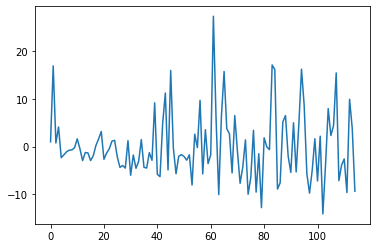

In [105]:
plt.plot(output_cube_data[:,80,40])

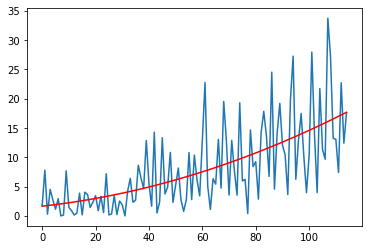

In [108]:
parameters, var = curve_fit(quadratic_function,np.arange(shape[0]),dhw_cube_detrended_1_data[:,156,20])
y_values_anomaly_from_curve = quadratic_function(np.arange(shape[0]), *parameters)
plt.plot(dhw_cube.data[:,156,20])
plt.plot(y_values_anomaly_from_curve,'r')

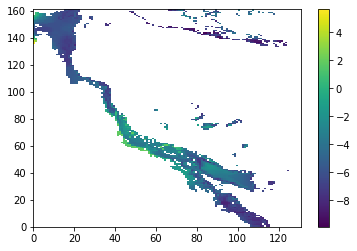

In [109]:
plt.pcolormesh(output_cube_data[70])
plt.colorbar()

In [17]:
## Cell 5
## Extract for ENSO event interested in

## Define extract_year_range_inclusive_1_years function for ENSO events that span across one year
def extract_year_range_inclusive_1_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month):
    
    try:  # Add year scalar coordinate
        iris.coord_categorisation.add_year(enso_dhw_cube,'time', name='year')
    except:
        pass
    try:  # Add month scalar coordinate
        iris.coord_categorisation.add_month(enso_dhw_cube,'time', name='month')
    except:
        pass
    try:  # Add month_number scalar coordinate
        iris.coord_categorisation.add_month_number(enso_dhw_cube,'time', name = 'month_number')
    except:
        pass
    
    # Constrain first part of ENSO event
    enso_event_year_1_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == start_year)
    enso_event_year_1_months = iris.Constraint(month_number=lambda tmp_mn: year_1_start_month <= tmp_mn <= year_1_end_month)
    enso_event_cube = enso_dhw_cube.extract(enso_event_year_1_year & enso_event_year_1_months)

    return enso_event_cube



## Define extract_year_range_inclusive_2_years function for ENSO events that span across 2 years
def extract_year_range_inclusive_2_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month,end_year,year_2_start_month,year_2_end_month):
    
    try:  # Add year scalar coordinate
        iris.coord_categorisation.add_year(enso_dhw_cube,'time', name='year')
    except:
        pass
    try:  # Add month scalar coordinate
        iris.coord_categorisation.add_month(enso_dhw_cube,'time', name='month')
    except:
        pass
    try:  # Add month_number scalar coordinate
        iris.coord_categorisation.add_month_number(enso_dhw_cube,'time', name = 'month_number')
    except:
        pass
    
    # Constrain first part of ENSO event
    enso_event_year_1_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == start_year)
    enso_event_year_1_months = iris.Constraint(month_number=lambda tmp_mn: year_1_start_month <= tmp_mn <= year_1_end_month)
    enso_event_year_1_cube = enso_dhw_cube.extract(enso_event_year_1_year & enso_event_year_1_months)
    #print(type(enso_event_year_1_cube))
    
    # Constrain second part of ENSO event
    enso_event_year_2_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == end_year)
    enso_event_year_2_months = iris.Constraint(month_number=lambda tmp_mn: year_2_start_month <= tmp_mn <= year_2_end_month)
    enso_event_year_2_cube = enso_dhw_cube.extract(enso_event_year_2_year & enso_event_year_2_months)
    #print(type(enso_event_year_1_cube))
    
    # Merge two cubes together
    enso_event_cube_list = iris.cube.CubeList([enso_event_year_1_cube, enso_event_year_2_cube])
    enso_event_cube = enso_event_cube_list.concatenate()[0]    
    #print(type(enso_event_year_1_cube))
          
    return enso_event_cube



## Define extract_year_range_inclusive_3_years function for ENSO events that span across 3 years
def extract_year_range_inclusive_3_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month,end_year,year_2_start_month,year_2_end_month,year_between,year_between_start_month,year_between_end_month):
    
    ## Only use this function if the ENSO event being investigated stretches across three years e.g. 2021,2022,2023
    
    try:  # Add year scalar coordinate
        iris.coord_categorisation.add_year(enso_dhw_cube,'time', name='year')
    except:
        pass
    try:  # Add month scalar coordinate
        iris.coord_categorisation.add_month(enso_dhw_cube,'time', name='month')
    except:
        pass
    try:  # Add month_number scalar coordinate
        iris.coord_categorisation.add_month_number(enso_dhw_cube,'time', name = 'month_number')
    except:
        pass
    
    # Constrain first part of ENSO event
    enso_event_year_1_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == start_year)
    enso_event_year_1_months = iris.Constraint(month_number=lambda tmp_mn: year_1_start_month <= tmp_mn <= year_1_end_month)
    enso_event_year_1_cube = enso_dhw_cube.extract(enso_event_year_1_year & enso_event_year_1_months)

    # Constrain second part of ENSO event
    enso_event_year_2_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == end_year)
    enso_event_year_2_months = iris.Constraint(month_number=lambda tmp_mn: year_2_start_month <= tmp_mn <= year_2_end_month)
    enso_event_year_2_cube = enso_dhw_cube.extract(enso_event_year_2_year & enso_event_year_2_months)
    
    # Constrain middle part of ENSO event
    enso_event_year_between_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == year_between)
    enso_event_year_between_months = iris.Constraint(month_number=lambda tmp_mn: year_2_start_month <= tmp_mn <= year_2_end_month)
    enso_event_year_between_cube = enso_dhw_cube.extract(enso_event_year_between_year & enso_event_year_between_months)
    
    # Merge three cubes together
    enso_event_cube_list = iris.cube.CubeList([enso_event_year_1_cube, enso_event_year_2_cube, enso_event_year_between_cube])
    enso_event_cube = enso_event_cube_list.concatenate()[0]    
   
    return enso_event_cube


In [18]:
## Define start and end month for specific ENSO events (GFDL-CM4 ssp2 (4.5))

# event_1
start_year = 2029
end_year = 2030
year_1_start_month = 11
year_1_end_month = 12
year_2_start_month = 1
year_2_end_month = 6

## Define new cube for ENSO event figure creation
enso_dhw_cube = dhw_cube_detrended_1.copy()
enso_event_name = (str(start_year)[0:4])+ "/" + (str(end_year)[2:4])
print(dhw_cube_name + " ENSO event: " + enso_event_name)
print("")
# ENSO events that span two years (use first function):
enso_event_cube = extract_year_range_inclusive_2_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month,end_year,year_2_start_month,year_2_end_month)
print(enso_event_cube)
print(enso_event_cube.data)
print(np.nanmin(enso_event_cube.data))
print(np.nanmax(enso_event_cube.data))


## Define function to calculate area mean
def area_avg(enso_event_cube):
    try:
        enso_event_cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        enso_event_cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(enso_event_cube)
    enso_event_area_mean = enso_event_cube.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)
    return enso_event_area_mean


# ## Filtering out crazy values and assigning them as a Nan
# enso_event_cube_data = enso_event_cube.data
# print(enso_event_cube_data)
# if np.nanmax(enso_event_cube_data) > 10000:
#     enso_event_cube_data[np.where(enso_event_cube_data > 10000)] = enso_event_cube_data.fill_value
#     enso_event_cube_data.mask[np.where(enso_event_cube_data > 10000)] = True
# if np.nanmax(enso_event_cube_data) > 10000:
#     enso_event_cube_data[np.where(enso_event_cube_data > 10000)] = enso_event_cube_data.fill_value
#     enso_event_cube_data.mask[np.where(enso_event_cube_data > 10000)] = True
    
## PAUL AND DAVID!  Call function to calculate area mean #########################################
enso_event_area_mean = area_avg(enso_event_cube)   # Call function to average over all grid squares
print(np.nanmax(enso_event_cube))
print(enso_event_area_mean)
print(enso_event_area_mean.data)

GFDL-CM4 ssp2(4.5) ENSO event: 2029/30

unknown / (1)                       (time: 242; latitude: 161; longitude: 131)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Auxiliary coordinates:
          month                          x              -               -
          month_number                   x              -               -
          year                           x              -               -
     Attributes:
          CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.7
          history: Thu May 27 15:42:01 2021: cdo mergetime GFDL-CM4_ssp245_1970_2100_surfacetemperature_1970.nc...
[[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- 

In [16]:
## Define start and end month for specific ENSO events (GFDL-CM4 ssp2 (4.5))

# # event_1
# start_year = 2029
# end_year = 2030
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6
    
# # event_2
# start_year = 2051
# end_year = 2052
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 5

# # event_3
# start_year = 2057
# end_year = 2058
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 5

# # event_4
# start_year = 2077
# end_year = 2078
# year_1_start_month = 12
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event_5
# start_year = 2084
# end_year = 2085
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event 6
# start_year = 2087
# end_year = 2088
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 5

##############################################################################################################


## Define start and end month for specific ENSO events (GFDL-CM4 ssp5 (8.5))

# # event_1
# start_year = 2021
# end_year = 2022
# year_1_start_month = 12
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event_2
# start_year = 2041
# end_year = 2042
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 5

# # event_3
# start_year = 2059
# end_year = 2060
# year_1_start_month = 12
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event_4
# start_year = 2063
# end_year = 2064
# year_1_start_month = 11
# year_1_start_month = 12
# year_2_start_month = 1
# year_2_end_month = 5

# # event_5 
# start_year = 2067
# end_year = 2068
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 5

# # event_6
# start_year = 2080
# end_year = 2081
# year_1_start_month = 12
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6


# ## Define new cube for ENSO event figure creation
# enso_dhw_cube = dhw_cube_detrended
# enso_event_name = (str(start_year)[0:4])+ "/" + (str(end_year)[2:4])
# print("ENSO event: " + enso_event_name)
# print("")

# ENSO events that span one year (use first function):
# enso_event_cube = extract_year_range_inclusive_1_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month)
# print(enso_event_cube)

# # ENSO events that span two years (use first function):
# enso_event_cube = extract_year_range_inclusive_2_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month,end_year,year_2_start_month,year_2_end_month)
# print(enso_event_cube)
# print(enso_event_cube.data)
# ENSO events that span three years (use second function):
# enso_event_cube = extract_year_range_inclusive_3_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month,end_year,year_2_start_month,year_2_end_month,year_between,year_between_start_month,year_between_end_month)
# print(enso_event_cube)

## PLotting
# enso_event_timeseries_title = dhw_cube_name + " " + str(start_year) + "/" + str(end_year) + " ENSO Area Mean DHW"
# qplt.plot(enso_event_area_mean)
# plt.xlim((dt.datetime(start_year, (year_1_start_month),1),dt.datetime(end_year,(year_2_end_month),1)))
# plt.title(enso_event_timeseries_title, pad=8)
# plt.xlabel("Time (Year-Month)")
# plt.ylabel("DHW")
# plt.xticks(rotation=35)
# plt.axvline(dt.datetime(start_year, year_1_start_month, 2),color="red",linestyle="--")
# plt.axvline(dt.datetime(end_year, year_2_end_month, 2),color="red",linestyle="--")

In [17]:
## Define start and end month for specific ENSO events (MIROC6 ssp2 (4.5))

# # event_1
# start_year = 2023
# end_year = 2024
# year_1_start_month = 10
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event_2
# start_year = 2028
# end_year = 2029
# year_1_start_month = 2
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event_3
# start_year = 2032
# end_year = 2033
# year_1_start_month = 12
# year_1_end_month = 12
# year_1_start_month = 1
# year_2_end_month = 8

# # event_4
# start_year = 2037
# end_year = 2038
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 7

# # event_5
# start_year = 2043
# end_year = 2044
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 7

# # event_6
# start_year = 2047
# year_betweeen = 2048
# end_year = 2049
# year_1_start_month = 12
# year_1_end_month = 12
# year_between_start_month = 1
# year_between_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 5

# # event_7
# start_year = 2052
# end_year = 2053
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event_8
# start_year = 2065
# end_year = 2066
# year_1_start_month = 9
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event_9
# start_year = 2072
# end_year = 2073
# year_1_start_month = 3
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event_10
# start_year = 2077
# end_year = 2077
# year_1_start_month = 1
# year_1_end_month = 7

# # event_11
# start_year = 2082
# end_year = 2083
# year_1_start_month = 9
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

##############################################################################################################

## Define start and end month for specific ENSO events (MIROC6 ssp5 (8.5))

# # event_1
# start_year = 2029
# end_year = 2030
# year_1_start_month = 1
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 8

# # event_2
# start_year = 2039
# end_year = 2040
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 7

# # event_3
# start_year = 2044
# year_between = 2045
# end_year = 2046
# year_1_start_month = 9
# year_1_end_month = 12
# year_between_start_month = 1
# year_between_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event_4
# start_year = 2049
# end_year = 2050
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 7

# # event_5
# start_year = 2056
# end_year = 2057
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 7

# # event_6
# start_year = 2062
# end_year = 2063
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 8

# # event_7
# start_year = 2069
# end_year = 2070
# year_1_start_month = 9
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 7

# # event_8
# start_year = 2074
# end_year = 2075
# year_1_start_month = 12
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 7

# # event_9
# start_year = 2079
# end_year = 2081
# year_between = 2080
# year_1_start_month = 11
# year_1_end_month = 12
# year_between_start_month = 1
# year_between_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event_10
# start_year = 2085
# end_year = 2086
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event_11
# start_year = 2089
# end_year = 2090
# year_1_start_month = 3
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 7


## Define new cube for ENSO event figure creation
# enso_dhw_cube = dhw_cube_detrended
# enso_event_name = (str(start_year)[0:4])+ "/" + (str(end_year)[2:4])
# print("ENSO event: " + enso_event_name)
# print("")

# ENSO events that span one year (use first function):
# enso_event_cube = extract_year_range_inclusive_1_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month)

# ENSO events that span two years (use second function):
# enso_event_cube = extract_year_range_inclusive_2_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month,end_year,year_2_start_month,year_2_end_month)

# ENSO events that span three years (use third function):
# enso_event_cube = extract_year_range_inclusive_3_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month,end_year,year_2_start_month,year_2_end_month,year_between,year_between_start_month,year_between_end_month)


In [18]:
## Define start and end month for specific ENSO events (UKESM1-0-LL ssp2 (4.5))

# # event_1
# start_year = 2030
# end_year = 2031
# year_1_start_month = 9
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event_2
# start_year = 2061
# end_year = 2062
# year_1_start_month = 12
# year_1_end_month  = 12
# year_1_start_month = 1
# year_2_end_month = 6

##############################################################################################################

## Define start and end month for specific ENSO events (UKESM1-0-LL ssp5 (8.5))

# # event_1
# start_year = 2026
# end_year = 2027
# year_1_start_month = 11
# year_1_end_month = 12
# year_2_start_month = 1
# year_2_end_month = 6

# # event_2
# start_year = 2088
# end_year = 2089
# year_1_start_month = 11
# year_1_end_month  = 12
# year_1_start_month = 1
# year_2_end_month = 6


# enso_event_name = (str(start_year)[0:4])+ "/" + (str(end_year)[2:4])
# print("ENSO event: " + enso_event_name)
# print("")

# # ENSO events that span two years (use second function):
# enso_event_cube = extract_year_range_inclusive_2_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month,end_year,year_2_start_month,year_2_end_month)


<class 'iris.cube.Cube'>

[[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -3.146892547607422 -3.094282865524292 ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -3.146991729736328 -3.0943846702575684 ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -3.1470909118652344 -3.0944862365722656 ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 ...

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -3.176814556121826 -3.1249442100524902 ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -3.1769142150878906 -3.1250462532043457 ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -

/home/cj362/anaconda3/envs/python27/lib/python2.7/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


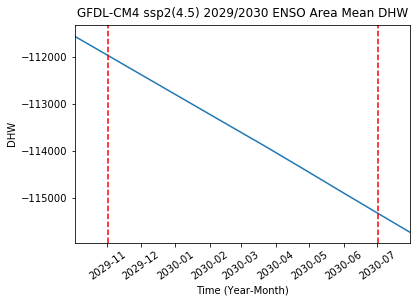

In [20]:
## Cell 6
## Plot timeseries of area mean daily dhw values

## Define extract_year_range_inclusive_1_years function for ENSO events that span across 1 year
# def extract_year_range_inclusive_1_years(enso_dhw_cube_timeseries,start_year,year_1_start_month_timseries,year_1_end_month_timeseries):
    
#     try:  # Add year scalar coordinate
#         iris.coord_categorisation.add_year(enso_dhw_cube_timeseries,'time', name='year')
#     except:
#         pass
#     try:  # Add month scalar coordinate
#         iris.coord_categorisation.add_month(enso_dhw_cube_timeseries,'time', name='month')
#     except:
#         pass
#     try:  # Add month_number scalar coordinate
#         iris.coord_categorisation.add_month_number(enso_dhw_cube_timeseries,'time', name = 'month_number')
#     except:
#         pass
    
#     # Constrain first part of ENSO event
#     enso_event_year_1_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == start_year)
#     enso_event_year_1_months = iris.Constraint(month_number=lambda tmp_mn: year_1_start_month_timseries <= tmp_mn <= year_1_end_month_timeseries)
#     enso_event_cube = enso_dhw_timeseries_cube.extract(enso_event_year_1_year & enso_event_year_1_months)

#     return enso_event_cube_timeseries



## Define extract_year_range_inclusive_2_years function for ENSO events that span across 2 years
def extract_year_range_inclusive_2_years_timeseries(enso_dhw_cube_timeseries,start_year,year_1_start_month_timseries,year_1_end_month_timeseries,end_year,year_2_start_month_timeseries,year_2_end_month_timeseries):
    
    try:  # Add year scalar coordinate
        iris.coord_categorisation.add_year(enso_dhw_cube_timeseries,'time', name='year')
    except:
        pass
    try:  # Add month scalar coordinate
        iris.coord_categorisation.add_month(enso_dhw_cube_timeseries,'time', name='month')
    except:
        pass
    try:  # Add month_number scalar coordinate
        iris.coord_categorisation.add_month_number(enso_dhw_cube_timeseries,'time', name = 'month_number')
    except:
        pass
    
    # Constrain first part of ENSO event
    enso_event_year_1_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == start_year)
    enso_event_year_1_months = iris.Constraint(month_number=lambda tmp_mn: year_1_start_month_timseries <= tmp_mn <= year_1_end_month_timeseries)
    enso_event_year_1_cube = enso_dhw_cube_timeseries.extract(enso_event_year_1_year & enso_event_year_1_months)
    #print(type(enso_event_year_1_cube))
    
    # Constrain second part of ENSO event
    enso_event_year_2_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == end_year)
    enso_event_year_2_months = iris.Constraint(month_number=lambda tmp_mn: year_2_start_month_timeseries <= tmp_mn <= year_2_end_month_timeseries)
    enso_event_year_2_cube = enso_dhw_cube_timeseries.extract(enso_event_year_2_year & enso_event_year_2_months)
    #print(type(enso_event_year_1_cube))
    
    # Merge two cubes together
    enso_event_cube_list = iris.cube.CubeList([enso_event_year_1_cube, enso_event_year_2_cube])
    enso_event_cube_timeseries = enso_event_cube_list.concatenate()[0]    
    #print(type(enso_event_year_1_cube))
          
    return enso_event_cube_timeseries




## Define extract_year_range_inclusive_3_years function for ENSO events that span across 3 years
# def extract_year_range_inclusive_3_years_timeseries(enso_dhw_cube_timeseries,start_year,year_1_start_month_timseries,year_1_end_month_timeseries,end_year,year_2_start_month_timeseries,year_2_end_month_timeseries,year_between,year_between_start_month,year_between_end_month):
    
#     ## Only use this function if the ENSO event being investigated stretches across three years e.g. 2021,2022,2023
    
#     try:  # Add year scalar coordinate
#         iris.coord_categorisation.add_year(enso_dhw_cube_timeseries,'time', name='year')
#     except:
#         pass
#     try:  # Add month scalar coordinate
#         iris.coord_categorisation.add_month(enso_dhw_cube_timeseries,'time', name='month')
#     except:
#         pass
#     try:  # Add month_number scalar coordinate
#         iris.coord_categorisation.add_month_number(enso_dhw_cube_timeseries,'time', name = 'month_number')
#     except:
#         pass
    
#     # Constrain first part of ENSO event
#     enso_event_year_1_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == start_year)
#     enso_event_year_1_months = iris.Constraint(month_number=lambda tmp_mn: year_1_start_month_timseries <= tmp_mn <= year_1_end_month_timeseries)
#     enso_event_year_1_cube = enso_dhw_timeseries_cube.extract(enso_event_year_1_year & enso_event_year_1_months)

#     # Constrain second part of ENSO event
#     enso_event_year_2_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == end_year)
#     enso_event_year_2_months = iris.Constraint(month_number=lambda tmp_mn: year_2_start_month_timeseries <= tmp_mn <= year_2_end_month_timeseries)
#     enso_event_year_2_cube = enso_dhw_timeseries_cube.extract(enso_event_year_2_year & enso_event_year_2_months)
    
#     # Constrain middle part of ENSO event
#     enso_event_year_between_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == year_between)
#     enso_event_year_between_months = iris.Constraint(month_number=lambda tmp_mn: year_between_start_month <= tmp_mn <= year_between_end_month)
#     enso_event_year_between_cube = enso_dhw_timeseries_cube.extract(enso_event_year_between_year & enso_event_year_between_months)
    
#     # Merge three cubes together
#     enso_event_cube_list = iris.cube.CubeList([enso_event_year_1_cube, enso_event_year_2_cube, enso_event_year_between_cube])
#     enso_event_cube_timeseries = enso_event_cube_list.concatenate()[0]    
   
#     return enso_event_cube_timeseries




## Define function to calculate area mean
def area_avg(enso_dhw_cube_timeseries):
    try:
        enso_dhw_cube_timeseries.coord('latitude').guess_bounds()
    except:
        pass
    try:
        enso_dhw_cube_timeseries.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(enso_dhw_cube_timeseries)
    enso_event_area_mean = enso_dhw_cube_timeseries.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)
    return enso_event_area_mean





## Define new cube for ENSO event figure creation
enso_dhw_cube_timeseries = enso_dhw_cube
print(type(enso_dhw_cube_timeseries))


## Define start and end month for specific ENSO event, different to previous cell so timeseries plot appears better
year_1_start_month_timseries = year_1_start_month - 1
year_1_end_month_timeseries = 12
year_2_start_month_timeseries = 1 
year_2_end_month_timeseries = year_2_end_month + 1
# year_between_start_month = 1
# year_between_end_month = 12


####################
# ENSO events that span two years (use first function):
# enso_event_cube_timeseries = enso_dhw_timeseries_cube
# enso_event_cube_timeseries = extract_year_range_inclusive_1_years_timeseries(enso_dhw_cube_timeseries,start_year,year_1_start_month_timseries,year_1_end_month_timeseries)

# ENSO events that span two years (use second function):
enso_event_cube_timeseries = extract_year_range_inclusive_2_years_timeseries(enso_dhw_cube_timeseries,start_year,year_1_start_month_timseries,year_1_end_month_timeseries,end_year,year_2_start_month_timeseries,year_2_end_month_timeseries)
print("")

# ENSO events that span three years (use second function):
# enso_event_cube_timeseries = extract_year_range_inclusive_3_years_timeseries(enso_dhw_cube_timeseries,start_year,year_1_start_month_timseries,year_1_end_month_timeseries,end_year,year_2_start_month_timeseries,year_2_end_month_timeseries,year_between,year_between_start_month,year_between_end_month)



## Filtering out crazy values and assigning them as a Nan
enso_event_cube_timeseries_data = enso_event_cube_timeseries.data
print(enso_event_cube_timeseries_data)
if np.nanmax(enso_event_cube_timeseries_data) > 10000:
    enso_event_cube_timeseries_data[np.where(enso_event_cube_timeseries_data > 10000)] = enso_event_cube_timeseries_data.fill_value
    enso_event_cube_timeseries_data.mask[np.where(enso_event_cube_timeseries_data > 10000)] = True
if np.nanmax(enso_event_cube_timeseries_data) > 10000:
    enso_event_cube_timeseries_data[np.where(enso_event_cube_timeseries_data > 10000)] = enso_event_cube_timeseries_data.fill_value
    enso_event_cube_timeseries_data.mask[np.where(enso_event_cube_timeseries_data > 10000)] = True
    
## PAUL AND DAVID!  Call function to calculate area mean #########################################
enso_event_area_mean = area_avg(enso_event_cube_timeseries)   # Call function to average over all grid squares
print(enso_event_area_mean)
print(enso_event_area_mean.data)


## PLotting
enso_event_timeseries_title = dhw_cube_name + " " + str(start_year) + "/" + str(end_year) + " ENSO Area Mean DHW"
qplt.plot(enso_event_area_mean)
plt.xlim((dt.datetime(start_year, (year_1_start_month_timseries), 3)),dt.datetime(end_year,(year_2_end_month_timeseries),30))
plt.title(enso_event_timeseries_title, pad=8)
plt.xlabel("Time (Year-Month)")
plt.ylabel("DHW")
plt.xticks(rotation=35)
plt.axvline(dt.datetime(start_year, year_1_start_month, 2),color="red",linestyle="--")
plt.axvline(dt.datetime(end_year, year_2_end_month_timeseries, 2),color="red",linestyle="--")
# savefig('/data/local_ssd/cj362/S2P3Rv2.0/dhw/enso_event_dhw_outputs/UKESM1_ssp245_dhw_annual_mean.png')


unknown / (1)                       (latitude: 161; longitude: 131)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          month: Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|No...
          month_number: 6, bound=(1, 12)
          time: 2030-03-01 12:00:00, bound=(2029-11-01 00:00:00, 2030-06-30 00:00:00)
          year: 2029, bound=(2029, 2030)
     Attributes:
          CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.7
          history: Thu May 27 15:42:01 2021: cdo mergetime GFDL-CM4_ssp245_1970_2100_surfacetemperature_1970.nc...
     Cell methods:
          sum: time
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- 1259.956787109375 1334.14453125 ... -- -- --]
 [-- --

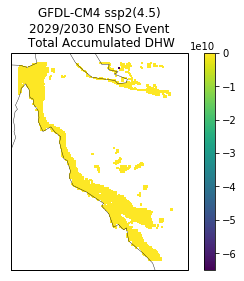

In [10]:
## Cell 7
## Calculate cumulative DHW for each grid square

## Re-load in iris cube containing dhw data
enso_events_total_dhw = enso_event_cube

## Filtering out crazy values and assigning them as a Nan
enso_events_total_dhw_data = enso_events_total_dhw.data
if np.nanmax(enso_events_total_dhw_data) > 1000:
    enso_events_total_dhw_data[np.where(enso_events_total_dhw_data > 1000)] = enso_events_total_dhw_data.fill_value
    enso_events_total_dhw_data.mask[np.where(enso_events_total_dhw_data > 1000)] = True
if np.nanmax(enso_events_total_dhw_data) < -1000:
    enso_events_total_dhw_data[np.where(enso_events_total_dhw_data < -1000)] = enso_events_total_dhw_data.fill_value
    enso_events_total_dhw_data.mask[np.where(enso_events_total_dhw_data < -1000)] = True

## Calculate value sum 
enso_events_total_dhw = enso_events_total_dhw.collapsed('time', iris.analysis.SUM)
print(enso_events_total_dhw)

## Plotting
colormesh = iplt.pcolormesh(enso_events_total_dhw)
# current_map = iplt.gcm()
# iplt.drawcoastlines()
plt.title("{0}\n{1}/{2} ENSO Event\n Total Accumulated DHW".format(dhw_cube_name,str(start_year),str(end_year)))
plt.colorbar(orientation = 'vertical')
plt.gca().coastlines(linewidth=0.4)

unknown / (1)                       (latitude: 161; longitude: 131)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          month: Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|No...
          month_number: 6, bound=(1, 12)
          time: 2030-03-01 12:00:00, bound=(2029-11-01 00:00:00, 2030-06-30 00:00:00)
          year: 2029, bound=(2029, 2030)
     Attributes:
          CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.7
          history: Thu May 27 15:42:01 2021: cdo mergetime GFDL-CM4_ssp245_1970_2100_surfacetemperature_1970.nc...
     Cell methods:
          maximum: time


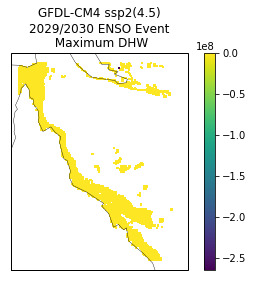

In [18]:
## Cell 8
## Calculate maximum DHW for each grid square

## Re-load in iris cube containing dhw data
enso_events_max_dhw = enso_event_cube

## Filtering out crazy values and assigning them as a Nan
enso_events_max_dhw_data = enso_events_max_dhw.data
if np.nanmax(enso_events_max_dhw_data) > 1000:
    enso_events_max_dhw_data[np.where(enso_events_max_dhw_data > 1000)] = enso_events_max_dhw_data.fill_value
    enso_events_max_dhw_data.mask[np.where(enso_events_max_dhw_data > 1000)] = True
if np.nanmax(enso_events_max_dhw_data) < -1000:
    enso_events_max_dhw_data[np.where(enso_events_max_dhw_data < -1000)] = enso_events_max_dhw_data.fill_value
    enso_events_max_dhw_data.mask[np.where(enso_events_max_dhw_data < -1000)] = True

## Calculate value sum 
enso_events_max_dhw = enso_events_max_dhw.collapsed('time', iris.analysis.MAX)
print(enso_events_max_dhw)

iplt.pcolormesh(enso_events_max_dhw)
plt.title("{0}\n{1}/{2} ENSO Event\n Maximum DHW".format(dhw_cube_name,str(start_year),str(end_year)))
plt.colorbar(orientation = 'vertical')
plt.gca().coastlines(linewidth=0.4)

unknown / (1)                       (latitude: 161; longitude: 131)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          month: Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|No...
          month_number: 6, bound=(1, 12)
          time: 2030-03-01 12:00:00, bound=(2029-11-01 00:00:00, 2030-06-30 00:00:00)
          year: 2029, bound=(2029, 2030)
     Attributes:
          CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.7
          history: Thu May 27 15:42:01 2021: cdo mergetime GFDL-CM4_ssp245_1970_2100_surfacetemperature_1970.nc...
     Cell methods:
          count: time


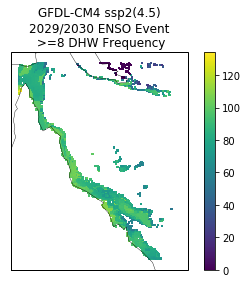

In [12]:
## Cell 9
## DHW bleaching thresholds plot 
## Plotting the number of times that each grid square reaches or exceeds 8 Degree Heating Weeks threshold

## Re-load in data
enso_events_eight_dhw = enso_event_cube

## Filtering out crazy values and assigning them as a Nan
enso_events_eight_dhw_data = enso_events_eight_dhw.data
if np.nanmax(enso_events_eight_dhw_data) > 1000:
    enso_events_eight_dhw_data[np.where(enso_events_eight_dhw_data > 1000)] = enso_events_eight_dhw_data.fill_value
    enso_events_eight_dhw_data.mask[np.where(enso_events_eight_dhw_data > 1000)] = True
if np.nanmax(enso_events_eight_dhw_data) < -1000:
    enso_events_eight_dhw_data[np.where(enso_events_eight_dhw_data < -1000)] = enso_events_eight_dhw_data.fill_value
    enso_events_eight_dhw_data.mask[np.where(enso_events_eight_dhw_data < -1000)] = True

enso_events_eight_dhw = enso_events_eight_dhw.collapsed('time', iris.analysis.COUNT,
                               function=lambda values: values >= 8)

print(enso_events_eight_dhw)

## Plotting
iplt.pcolormesh(enso_events_eight_dhw)
plt.title("{0}\n{1}/{2} ENSO Event\n >=8 DHW Frequency".format(dhw_cube_name,str(start_year),str(end_year)))
plt.colorbar(orientation = 'vertical')
plt.gca().coastlines(linewidth=0.4)

242

23284
37709
74098
207348
[23284, 37709, 74098, 207348]
['1<=X<2', '2<=X<4', '4<=X<8', '8<=X']


<BarContainer object of 4 artists>

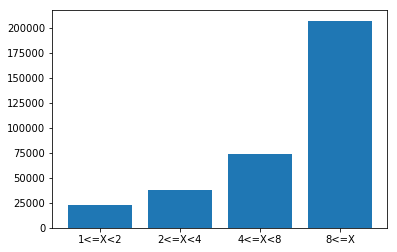

In [13]:
## Cell 10
## Bar chart of DHW threshold occurences
# Trying to plot a bar chart of the number of times that different DHW thresholds were crossed...
# ...totalled from across all grid squares.

# Define function to count the occurences of different DHW thresholds being crossed
def threshold_count(enso_events_dhw_thresholds_data):
    
    enso_event_dhw_1_count = np.sum((1 <= enso_events_dhw_thresholds_data) & (enso_events_dhw_thresholds_data < 2))
    enso_event_dhw_2_count = np.sum((2 <= enso_events_dhw_thresholds_data) & (enso_events_dhw_thresholds_data < 4))
    enso_event_dhw_4_count = np.sum((4 <= enso_events_dhw_thresholds_data) & (enso_events_dhw_thresholds_data < 8))
    enso_event_dhw_8_count = np.sum( 8 <= enso_events_dhw_thresholds_data )
    
    
#     # Define different threshold counts
#     enso_event_dhw_1_count = 0
#     enso_event_dhw_2_count = 0
#     enso_event_dhw_4_count = 0
#     enso_event_dhw_8_count = 0
        
#     # Create for loop to examine all data
#     for i in range(0, len(enso_events_dhw_thresholds_data[:,0,0])):
        
#         ## PROBLEM IN LINE ABOVE:have tried solutions relating to .any() and .all(), as well as .compressed()
        

    
#         # Define if statements to segment different threshold counts
#         test1 = np.where((enso_events_dhw_thresholds_data[i,:,:] >= 1.0) & (enso_events_dhw_thresholds_data[i,:,:] < 2.0))
#         if np.logical_not(test1[0].size == 0):
#             enso_event_dhw_1_count = enso_event_dhw_1_count + 1

#         test2 = np.where((enso_events_dhw_thresholds_data[i,:,:] >= 2.0) & (enso_events_dhw_thresholds_data[i,:,:] < 4.0))
#         if np.logical_not(test2[0].size == 0):
#             enso_event_dhw_2_count = enso_event_dhw_2_count + 1
            
#         test3 = np.where((enso_events_dhw_thresholds_data[i,:,:] >= 4.0) & (enso_events_dhw_thresholds_data[i,:,:] < 8.0))
#         if np.logical_not(test3[0].size == 0):
#             enso_event_dhw_4_count = enso_event_dhw_4_count + 1

#         test4 = np.where((enso_events_dhw_thresholds_data[i,:,:] >= 8.0) & (enso_events_dhw_thresholds_data[i,:,:] < 1000.0))
#         if np.logical_not(test4[0].size == 0):
#             enso_event_dhw_8_count = enso_event_dhw_8_count + 1
        
       
    return enso_event_dhw_1_count, enso_event_dhw_2_count, enso_event_dhw_4_count, enso_event_dhw_8_count


## Re-load in DHW data
enso_events_dhw_thresholds = enso_event_cube
enso_events_dhw_thresholds_data = enso_events_dhw_thresholds.data
print(len(enso_events_dhw_thresholds_data))
print("")
# print(enso_events_dhw_thresholds_data)
# print(type(enso_events_dhw_thresholds_data))

## Call upon function to examine data
enso_event_dhw_1_count, enso_event_dhw_2_count, enso_event_dhw_4_count, enso_event_dhw_8_count = threshold_count(enso_events_dhw_thresholds_data)

print(enso_event_dhw_1_count)
print(enso_event_dhw_2_count)
print(enso_event_dhw_4_count)
print(enso_event_dhw_8_count)


dhw_thresholds_data = []
dhw_thresholds_data.append(enso_event_dhw_1_count)
dhw_thresholds_data.append(enso_event_dhw_2_count)
dhw_thresholds_data.append(enso_event_dhw_4_count)
dhw_thresholds_data.append(enso_event_dhw_8_count)
print(dhw_thresholds_data)

dhw_thresholds = []
dhw_thresholds.append("1<=X<2")
dhw_thresholds.append("2<=X<4")
dhw_thresholds.append("4<=X<8")
dhw_thresholds.append("8<=X")
print(dhw_thresholds)

plt.bar(dhw_thresholds,dhw_thresholds_data)
